# Plot global sea level change

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline

## Load GFDL model output

In [2]:
mem_ESM4 = ['D1', 'D151', 'D201']
#mem_CM4 = ['251', '290', '332']
mem_CM4 =['251']
#mem_CM4 = mem_CM4+['noBling_290', 'noBling_332']

In [3]:
ncdir='/scratch/cimes/jt7058/data/interim/'
zrdir = '/scratch/cimes/jt7058/data/zarr/'

varnames = ['zos','zostoga']
ddict = {mod:{} for mod in ['CM4','CM4Xp25','CM4Xp125']}

for mod in ddict:
    
    if mod=='CM4':
        grdir = '/scratch/cimes/jt7058/data/raw/CM4_piControl_C/ocean_monthly/'
        grid = xr.open_dataset(grdir+'ocean_monthly.static.nc')
        da_mask = xr.open_dataset('/scratch/cimes/jt7058/data/static/p25_tm14_region_mask.nc').tm14_region
    elif mod=='CM4Xp25':
        grdir = '/scratch/cimes/jt7058/data/static/'
        grid = xr.open_dataset(grdir+'p25_ocean_monthly.static.nc')
        grid['basin'] = xr.open_dataset('/scratch/cimes/jt7058/data/static/CM4Xp25_bmask.nc').basin
        da_mask = xr.open_dataset('/scratch/cimes/jt7058/data/static/CM4Xp25_tm14_region_mask.nc').tm14_region
    elif mod=='CM4Xp125':
        grdir = '/scratch/cimes/jt7058/data/static/'
        grid = xr.open_dataset(grdir+'p125_ocean_monthly.static.nc')
        grid['basin'] = xr.open_dataset('/scratch/cimes/jt7058/data/static/CM4Xp125_bmask.nc').basin
        da_mask = xr.open_dataset('/scratch/cimes/jt7058/data/static/CM4Xp125_tm14_region_mask.nc').tm14_region
    else:
        print('grid is not available for '+mod)
        
    da_mask = da_mask.where(da_mask != -1)
    grid['tm14_region'] = xr.DataArray(da_mask.values, dims=('yh', 'xh'), 
                                       coords={'yh': grid.yh.values, 'xh': grid.xh.values})
    
    ddict_exp = {exp:{} for exp in ['piControl','historical','ssp585']}
    for exp in ddict_exp:
        
        if (mod=='CM4') & (exp=='piControl'):
            head = mod+'_'+exp+'_C'
        elif mod=='CM4Xp25':
            head = 'CM4_piControl_c192_OM4p25_v8' if exp=='piControl' else 'CM4_%s_c192_OM4p25'%exp
        elif mod=='CM4Xp125':
            head = 'CM4_piControl_c192_OM4p125_v7' if exp=='piControl' else 'CM4_%s_c192_OM4p125'%exp
        else:
            head = mod+'_'+exp+'_%s'
            
        print('\n',head)
        
        for var in varnames:
            if var=='zostoga':
                fname = '%s_global_*_%s_ref_monthly'%(head,var) if exp=='ssp585' \
                        else '%s_global_*_%s_monthly'%(head,var)
            else:
                fname = '%s_global_*_%s_monthly'%(head,var)
            
            # Multiple members, Multiple files
            if (mod in ['CM4','ESM4']) & (exp in ['historical','ssp585']):
                
                das = []
                mems = mem_ESM4 if mod=='ESM4' else mem_CM4
                for mem in mems:
                    if var in ['zos', 'steric']:
                        files = glob.glob(zrdir+fname%mem)
                    else:
                        files = glob.glob(ncdir+fname%mem+'.nc')
                    
                    if len(files)>1:
                        print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'-'+mem+'. Please specify.')
                    elif len(files)==0:
                        print('ERROR: No file available for '+var+' in '+mod+'-'+exp+'-'+mem)
                        #print(fname%mem)
                        continue
                    
                    print('Loading '+files[0])
                    if var in ['zos', 'steric']:
                        da = xr.open_zarr(files[0])['steric_sea_level' if var=='steric' else var]
                    else:
                        da = xr.open_dataset(files[0])['tas' if var=='tref' else var]
                        
                    da['mem'] = mem
                    das.append(da)
                
                if var=='zos':
                    ds_tmp = xr.open_zarr(files[0])
                    ds = xr.merge([xr.concat(das, dim='mem'),ds_tmp.drop('zos')])
                    ds['basin'] = grid.basin
                    ds['tm14_region'] = grid.tm14_region
                else:
                    ds[var] = xr.concat(das, dim='mem')
            # Single file (piControl and SPEAR)
            else:
                if var in ['zos', 'steric']:
                    files = glob.glob(zrdir+fname)
                else:
                    files = glob.glob(ncdir+fname+'.nc')
                        
                if len(files)>1:
                    print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'. Please specify.')
                elif len(files)==0:
                    print('ERROR: No file available for '+var+' in '+mod+'-'+exp)
                    print(fname)
                    continue
                    
                print('Loading '+files[0])
                
                if var=='zos':
                    ds = xr.open_zarr(files[0])
                    ds['basin'] = grid.basin
                    ds['tm14_region'] = grid.tm14_region
                elif var=='steric':
                    ds[var] = xr.open_zarr(files[0])['steric_sea_level']
                else:
                    ds[var] = xr.open_dataset(files[0])['tas' if var=='tref' else var]
            
        if (mod in ['CM4Xp25','CM4Xp125']) & (exp in ['historical','ssp585']):
            print('Create new dimension "mem"')
            ds = ds.expand_dims({'mem': 1})
            
        ddict_exp[exp] = ds#.sel(time=slice('1921' if exp=='historical' else None, None))
        del ds
    ddict[mod] = ddict_exp


 CM4_piControl_C
Loading /scratch/cimes/jt7058/data/zarr/CM4_piControl_C_global_0001to0650_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_piControl_C_global_0001to0650_zostoga_monthly.nc

 CM4_historical_%s
Loading /scratch/cimes/jt7058/data/zarr/CM4_historical_251_global_1850to2014_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_historical_251_global_1850to2014_zostoga_monthly.nc

 CM4_ssp585_%s
Loading /scratch/cimes/jt7058/data/zarr/CM4_ssp585_251_global_2015to2100_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_ssp585_251_global_2015to2100_zostoga_ref_monthly.nc

 CM4_piControl_c192_OM4p25_v8
Loading /scratch/cimes/jt7058/data/zarr/CM4_piControl_c192_OM4p25_v8_global_0101to0350_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_piControl_c192_OM4p25_v8_global_0101to0350_zostoga_monthly.nc

 CM4_historical_c192_OM4p25
Loading /scratch/cimes/jt7058/data/zarr/CM4_historical_c192_OM4p25_global_1850to2014_zos_monthly
Loading /scratch/cimes/jt70

### Branch-off years

In [4]:
yr_init = {}

# Keep full historical for CM4 and ESM4
shift_init_yr = 0
yr_init['CM4'] = np.array([int(s.split('_')[-1]) for s in ddict['CM4']['historical'].mem.to_numpy()])+shift_init_yr
yr_init['CM4Xp25'] = np.array([101])+shift_init_yr
yr_init['CM4Xp125'] = np.array([101])+shift_init_yr

## Load observational estimates

In [5]:
obsdir = '/scratch/cimes/jt7058/data/'

### Frederikse et al. (2020)

In [6]:
# Reading all the sheets from the Excel file into a dictionary of dataframes
ddict_df = pd.read_excel(obsdir+'frederikse2020/global_basin_timeseries.xlsx', 
                         sheet_name=None,index_col=0)

In [7]:
name = 'Global'
component = 'Steric'
df = ddict_df[name]

### Load Thermosteric sea level change reconstrunction (Zanna et al., 2019)
The datasets for the upper 300 m, upper 700 m, upper 2000 m, below 2000 m, and full depth (with errors defined as one-SD and derived from perturbing the Green’s Functions and from the use of different SSTs).

In [8]:
layer = 'full_depth'

In [9]:
ds = xr.open_dataset(obsdir+'zanna2019/ThSL_GF_1870_2018.nc')
ds['year'] = xr.DataArray(np.linspace(1870,2018,149).astype(np.int32),dims=['time (starting 1870)'])
ds = ds.swap_dims({'time (starting 1870)':'year'}).drop_vars('time')
df_Z19 = (ds[f'ThSL_{layer}'] - ds[f'ThSL_{layer}'].sel(year=slice(2002,2018)).mean('year')).to_dataframe(name='ThSL_mean')

In [10]:
df_Z19['ThSL_lower'] = df_Z19.ThSL_mean - 2*ds[f'error_ThSL_{layer}'].to_series()
df_Z19['ThSL_upper'] = df_Z19.ThSL_mean + 2*ds[f'error_ThSL_{layer}'].to_series()

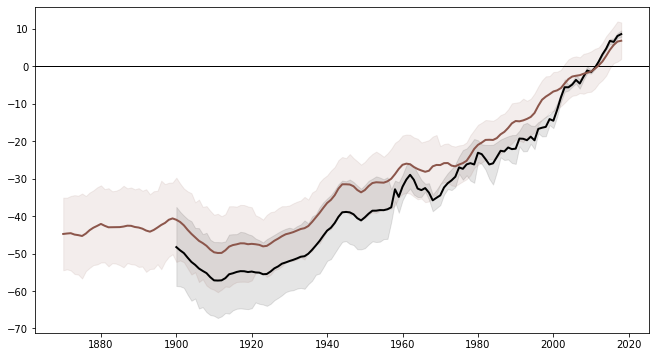

In [11]:
component = 'Steric'
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.fill_between(df.index, df[f'{component} [lower]'], df[f'{component} [upper]'], alpha=0.1, color='k')
ax.fill_between(df_Z19.index, df_Z19.ThSL_lower, df_Z19.ThSL_upper, alpha=0.1, color='tab:brown')
ax.plot(df.index, df[f'{component} [mean]'], label=name, linewidth=2, color='k')
ax.plot(df_Z19.index, df_Z19.ThSL_mean, label='Zanna', linewidth=2, color='tab:brown')
plt.show()

### Levitus et al. (2012)

In [12]:
datatype = 'total_steric' # total_steric, thermosteric
lyertype = '2000' # 100, 700, 2000
prd = 'pentad' # seasonal, yearly pentad
filename = 'mean_%s_sea_level_anomaly_0-%s_%s.nc'%(datatype,lyertype,prd)
ds = xr.open_dataset(obsdir+'levitus2012/'+filename,decode_times=False)

In [13]:
# Convert month offsets into actual datetime objects
dates = [pd.Timestamp('1955-01-01 00:00:00') + pd.DateOffset(months=int(month)) for month in ds.time.values]

ds['year'] = xr.DataArray([date.year for date in dates],dims=['time'])
ds = ds.swap_dims({'time':'year'}).drop_vars('time')

In [14]:
df_L12 = (ds.pent_s_mm_WO - ds.pent_s_mm_WO.sel(year=slice(2002,2018)).mean('year')).to_dataframe(name='Steric (Levitus2012) [mean]')
df_L12['Steric (Levitus2012) [lower]'] = df_L12['Steric (Levitus2012) [mean]'] - 2*ds.pent_s_mm_se_WO.to_series()
df_L12['Steric (Levitus2012) [upper]'] = df_L12['Steric (Levitus2012) [mean]'] + 2*ds.pent_s_mm_se_WO.to_series()

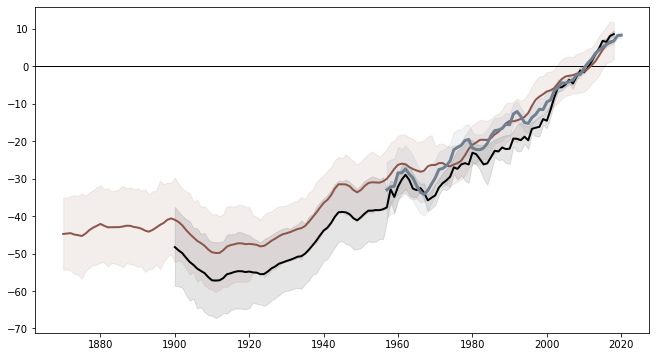

In [15]:
component = 'Steric'
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.fill_between(df.index, df[f'{component} [lower]'], df[f'{component} [upper]'], alpha=0.1, color='k')
ax.fill_between(df_Z19.index, df_Z19.ThSL_lower, df_Z19.ThSL_upper, alpha=0.1, color='tab:brown')
ax.fill_between(df_L12.index, df_L12[f'{component} (Levitus2012) [lower]'], 
                df_L12[f'{component} (Levitus2012) [upper]'], alpha=0.1, color='slategrey')
ax.plot(df.index, df[f'{component} [mean]'], label='Frederikse', linewidth=2, color='k')
ax.plot(df_Z19.index, df_Z19.ThSL_mean, label='Zanna', linewidth=2, color='tab:brown')
ax.plot(df_L12.index, df_L12[f'{component} (Levitus2012) [mean]'], label='Levitus', linewidth=3, color='slategrey', ls = '-')

plt.show()

### Cheng et al. (2017)

In [16]:
df_C17_mon = pd.read_csv(obsdir+'cheng2017/IAP_Steric_sea_level_data.txt', delimiter=r'\s+', 
                         skiprows=15, header=None, index_col=None,
                         names=['year', 'month', 'SSL0to300m','SSL0to300m_95CI', 'SSL0to700m', 'SSL0to700m_95CI', 
                                'SSL0to2000m','SSL0to2000m_95CI','0','1','2']).iloc[:,:-3]
df_C17_mon['time'] = pd.to_datetime(df_C17_mon[['year', 'month']].assign(DAY=15))
df_C17_mon = df_C17_mon.set_index('time')

In [17]:
df_C17_anm = pd.DataFrame()
for int_layer in [300, 700, 2000]:
    df_C17_anm['SSL0to%sm'%str(int_layer)] = df_C17_mon['SSL0to%sm'%str(int_layer)]
    df_C17_anm['SSL0to%sm_lower'%str(int_layer)] = df_C17_mon['SSL0to%sm'%str(int_layer)]-df_C17_mon['SSL0to%sm_95CI'%str(int_layer)]
    df_C17_anm['SSL0to%sm_upper'%str(int_layer)] = df_C17_mon['SSL0to%sm'%str(int_layer)]+df_C17_mon['SSL0to%sm_95CI'%str(int_layer)]

In [18]:
df_C17_anm = df_C17_anm.resample('Y').mean()
df_C17_anm['year'] = df_C17_anm.index.year
df_C17_anm = df_C17_anm.set_index('year')

In [19]:
df_C17 = pd.DataFrame()
df_C17['Steric (Cheng2017) [mean]'] = df_C17_anm.SSL0to2000m - df_C17_anm.loc[2002:2018].mean(axis=0).SSL0to2000m
df_C17['Steric (Cheng2017) [lower]'] = df_C17_anm.SSL0to2000m_lower - df_C17_anm.loc[2002:2018].mean(axis=0).SSL0to2000m_lower
df_C17['Steric (Cheng2017) [upper]'] = df_C17_anm.SSL0to2000m_upper - df_C17_anm.loc[2002:2018].mean(axis=0).SSL0to2000m_upper

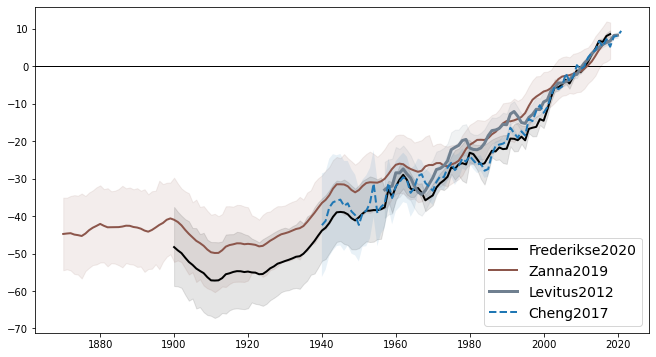

In [20]:
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.fill_between(df.index, df[f'{component} [lower]'], df[f'{component} [upper]'], alpha=0.1, color='k')
ax.fill_between(df_Z19.index, df_Z19.ThSL_lower, df_Z19.ThSL_upper, alpha=0.1, color='tab:brown')
ax.fill_between(df_L12.index, df_L12[f'{component} (Levitus2012) [lower]'], 
                df_L12[f'{component} (Levitus2012) [upper]'], alpha=0.1, color='slategrey')
ax.fill_between(df_C17.index, df_C17[f'{component} (Cheng2017) [lower]'], df_C17[f'{component} (Cheng2017) [upper]'], alpha=0.1)

ax.plot(df.index, df[f'{component} [mean]'], label='Frederikse2020', linewidth=2, color='k')
ax.plot(df_Z19.index, df_Z19.ThSL_mean, label='Zanna2019', linewidth=2, color='tab:brown')
ax.plot(df_L12.index, df_L12[f'{component} (Levitus2012) [mean]'], label='Levitus2012', linewidth=3, color='slategrey', ls = '-')
ax.plot(df_C17.index, df_C17[f'{component} (Cheng2017) [mean]'], label='Cheng2017', linewidth=2, ls = '--')

ax.legend(loc='lower right',fontsize=14)
plt.show()

### Ishii et al. (2017)

Ishii, M., Y. Fukuda, H. Hirahara, S. Yasui, T. Suzuki, and K. Sato, 2017: Accuracy of Global Upper Ocean Heat Content Estimation Expected from Present Observational Data Sets. SOLA, Vol. 13, 163-167, doi:10.2151/sola.2017-030.

In [21]:
df_I17_raw = pd.read_csv(obsdir+'ishii2017/Thermosteric_0-2000.txt', delim_whitespace=True, 
                         header=None, index_col=None, names=['Year','SLR','SLR_err']).set_index('Year')

In [22]:
df_I17_raw['SLR_lower'] = df_I17_raw.SLR-df_I17_raw.SLR_err
df_I17_raw['SLR_upper'] = df_I17_raw.SLR+df_I17_raw.SLR_err

In [23]:
df_I17 = pd.DataFrame()
df_I17['Steric (Ishii2017) [mean]'] = df_I17_raw.SLR - df_I17_raw.loc[2002:2018].mean(axis=0).SLR
df_I17['Steric (Ishii2017) [lower]'] = df_I17['Steric (Ishii2017) [mean]'] - 2*df_I17_raw.SLR_err
df_I17['Steric (Ishii2017) [upper]'] = df_I17['Steric (Ishii2017) [mean]'] + 2*df_I17_raw.SLR_err

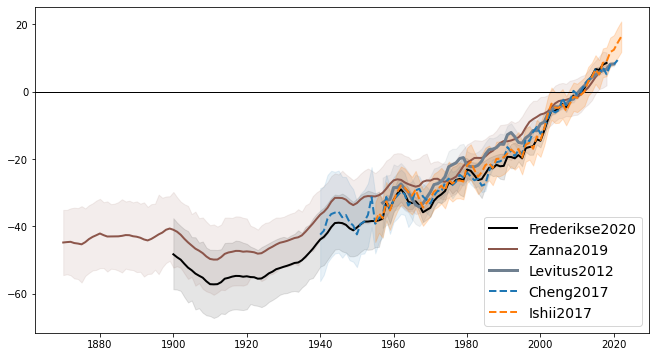

In [24]:
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.fill_between(df.index, df[f'{component} [lower]'], df[f'{component} [upper]'], alpha=0.1, color='k')
ax.fill_between(df_Z19.index, df_Z19.ThSL_lower, df_Z19.ThSL_upper, alpha=0.1, color='tab:brown')
ax.fill_between(df_L12.index, df_L12[f'{component} (Levitus2012) [lower]'], 
                df_L12[f'{component} (Levitus2012) [upper]'], alpha=0.1, color='slategrey')
ax.fill_between(df_C17.index, df_C17[f'{component} (Cheng2017) [lower]'], 
                df_C17[f'{component} (Cheng2017) [upper]'], color='tab:blue',
                alpha=0.1)
ax.fill_between(df_I17.index, df_I17[f'{component} (Ishii2017) [lower]'], 
                df_I17[f'{component} (Ishii2017) [upper]'], 
                color='tab:orange', alpha=0.2)
ax.plot(df.index, df[f'{component} [mean]'], label='Frederikse2020', linewidth=2, color='k')
ax.plot(df_Z19.index, df_Z19.ThSL_mean, label='Zanna2019', linewidth=2, color='tab:brown')
ax.plot(df_L12.index, df_L12[f'{component} (Levitus2012) [mean]'], label='Levitus2012', linewidth=3, 
        color='slategrey', ls = '-')
ax.plot(df_C17.index, df_C17[f'{component} (Cheng2017) [mean]'], label='Cheng2017', linewidth=2, ls = '--')
ax.plot(df_I17.index, df_I17[f'{component} (Ishii2017) [mean]'], label='Ishii2017', linewidth=2, ls = '--')
ax.legend(loc='lower right',fontsize=14)
plt.show()

## Global mean sea level

In [25]:
var = 'zostoga'
df_mod = pd.DataFrame()    
ddict_mod_dtr = {mod:{} for mod in ddict}

for i, mod in enumerate(ddict):
    print('\n',mod)
    
    das = []
    for j, mem in enumerate(ddict[mod]['historical'][var].mem.values):
        print(mem)
        
        first_yr_historical = int(ddict[mod]['historical'].time.dt.year[0].values)
        last_yr_ssp585 = int(ddict[mod]['ssp585'].time.dt.year[-1].values)
        yr_st = yr_init[mod][j]
        yr_ed = yr_init[mod][j]+(last_yr_ssp585-first_yr_historical)
        print(yr_st,yr_ed)
        print('Year range for contol: %s-%s'%(str(yr_st),str(yr_ed)))
        da_ctr = ddict[mod]['piControl'].sel(time=slice(str(yr_st).rjust(4, '0'),
                                                        str(yr_ed).rjust(4, '0')))[var]\
                    .groupby('time.year').mean('time')
        
        # Get Linear fit from pre-industrial control simulation (180 years <-- 1921-2100)
        print('Control (%s):'%var, str(da_ctr.year.values[0]), 'to', str(da_ctr.year.values[-1]))
        p = da_ctr.polyfit(dim='year', deg=1)
        fit = xr.polyval(da_ctr.year, p.polyfit_coefficients)
        
        da_raw = xr.concat([ddict[mod]['historical'][var].sel(mem=mem),
                            ddict[mod]['ssp585'][var].sel(mem=mem, 
                                                          time=slice('2011' if mod=='SPEAR' else '2015',None))], 
                           dim='time').groupby('time.year').mean('time')
        print('Historical+Scenario (%s):'%var,str(da_raw.year.values[0]),'to',
              str(da_raw.year.values[-1]),', n = %d'%len(da_raw))
        
        nyrs_shift = da_raw.year[0] - yr_st
        fit['year'] = fit.year + nyrs_shift
        print('Fit shifted by %s years:'%str(int(nyrs_shift.values)),str(fit.year.values[0]),'to',
              str(fit.year.values[-1])[:10])
        
        if fit.year.values[-1]<da_raw.year.values[-1]:
            print('WARNING: Control fit is too short. Need to extrapolate.')
            fit = fit.interp(year=xr.DataArray(range(int(da_raw.year[0].values), da_raw.index[-1]+1), 
                                               dims=('year'), name='year'),
                             method='linear',kwargs={'fill_value': 'extrapolate'})
            print('Fit extrapolated to have year range %s-%s'%(str(fit.year.values[0]),
                                                               str(fit.year.values[-1])[:10]))
            
        da = da_raw - fit
        das.append(da)
    da_dtr = xr.concat(das, dim='mem')
    
    # Remove present-day climatology 
    da_clm = da_dtr.sel(year=slice(2002,2018)).mean('year')
    da_anm = da_dtr - da_clm
    
    # Add the Series to the DataFrame (All models will have the same time period)
    #df_mod[mod+'_mean'] = da_anm.mean('mem').sel(year=slice(None,2018)).to_series()*1000
    #df_mod[mod+'_std'] = da_anm.std('mem').sel(year=slice(None,2018)).to_series()*1000
    
    # Use the merge function to keep years where SPEAR is NaN (<1921)
    y_mean = da_anm.mean('mem').sel(year=slice(None, 2022)).to_series()*1000
    df_tmp = y_mean.to_frame(name=mod+'_mean')
    df_tmp[mod+'_std'] = da_anm.std('mem').sel(year=slice(None,2022)).to_series()*1000
    df_mod = df_mod.merge(df_tmp, left_index=True, right_index=True, how='outer')

    ddict_mod_dtr[mod] = da_dtr*1000
    #print(df_mod)


 CM4
251
251 501
Year range for contol: 251-501
Control (zostoga): 251 to 501
Historical+Scenario (zostoga): 1850 to 2100 , n = 251
Fit shifted by 1599 years: 1850 to 2100

 CM4Xp25
0
101 350
Year range for contol: 101-350
Control (zostoga): 101 to 350
Historical+Scenario (zostoga): 1850 to 2099 , n = 250
Fit shifted by 1749 years: 1850 to 2099

 CM4Xp125
0
101 350
Year range for contol: 101-350
Control (zostoga): 101 to 350
Historical+Scenario (zostoga): 1850 to 2099 , n = 250
Fit shifted by 1749 years: 1850 to 2099


### CM4X assessment

In [26]:
dirstix = '/home/jt7058/stixfonts-master/fonts/static_ttf'
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [48]:
cstr = ['orange', 'k', 'brown']
lab_str_mod = ['CM4.0', 'CM4Xp25', 'CM4Xp125']
cstr_obs = ['tab:cyan', 'cyan', 'tab:cyan', 'tab:cyan','tab:cyan']

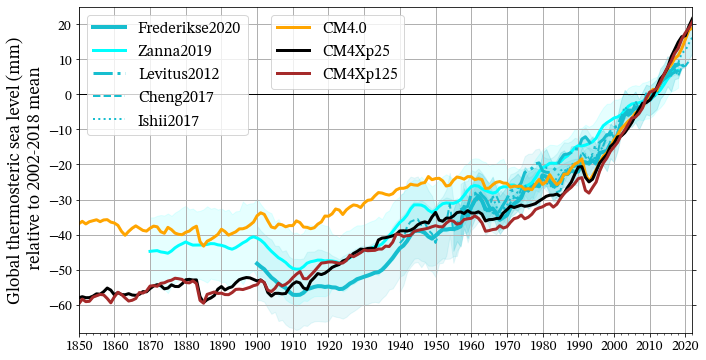

In [49]:
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

ax.fill_between(df.index, df[f'{component} [lower]'], df[f'{component} [upper]'], alpha=0.1, color=cstr_obs[0])
ax.fill_between(df_Z19.index, df_Z19.ThSL_lower, df_Z19.ThSL_upper, alpha=0.1, color=cstr_obs[1])
ax.fill_between(df_L12.index, df_L12[f'{component} (Levitus2012) [lower]'], 
                df_L12[f'{component} (Levitus2012) [upper]'], alpha=0.1, color=cstr_obs[2])
ax.fill_between(df_C17.index, df_C17[f'{component} (Cheng2017) [lower]'], 
                df_C17[f'{component} (Cheng2017) [upper]'], 
                color=cstr_obs[3],alpha=0.1)
ax.fill_between(df_I17.index, df_I17[f'{component} (Ishii2017) [lower]'], 
                df_I17[f'{component} (Ishii2017) [upper]'], 
                color=cstr_obs[4], alpha=0.2)

p_obs = []
p, = ax.plot(df.index, df[f'{component} [mean]'], label='Frederikse2020', linewidth=4, color=cstr_obs[0])
p_obs.append(p)

p, = ax.plot(df_Z19.index, df_Z19.ThSL_mean, label='Zanna2019', linewidth=3, color=cstr_obs[1])
p_obs.append(p)

p, = ax.plot(df_L12.index, df_L12[f'{component} (Levitus2012) [mean]'], label='Levitus2012', linewidth=3, 
             color=cstr_obs[2], ls = '-.')
p_obs.append(p)

p, = ax.plot(df_C17.index, df_C17[f'{component} (Cheng2017) [mean]'], label='Cheng2017', linewidth=2, 
             ls = '--', color=cstr_obs[3])
p_obs.append(p)

p, = ax.plot(df_I17.index, df_I17[f'{component} (Ishii2017) [mean]'], label='Ishii2017', linewidth=2, 
             ls = ':', color=cstr_obs[4])
p_obs.append(p)

# Create first legend (temporary)
first_legend = ax.legend(handles=p_obs, loc='upper left', fontsize=16)
ax.add_artist(first_legend)

p_mod = []
for j, col in enumerate([col.split('_')[0] for col in df_mod.columns if 'mean' in col]):
    #print(col)
    ax.fill_between(df_mod.index, df_mod[col+'_mean']-2*df_mod[col+'_std'], 
                    df_mod[col+'_mean']+2*df_mod[col+'_std'], 
                    alpha=0.2, edgecolor=cstr[j], facecolor=cstr[j])
    p, = ax.plot(df_mod.index, df_mod[col + '_mean'], linewidth=3, color=cstr[j], label=lab_str_mod[j])
    p_mod.append(p)
    
# Create the second legend with the remaining lines
second_legend = ax.legend(handles=p_mod, loc='upper left', bbox_to_anchor=(0.3, 1), fontsize=16)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Global thermosteric sea level (mm)\n relative to 2002-2018 mean', fontsize=18)
ax.set_xlabel('')
ax.set_xlim([1850, 2022])
ax.set_xlim([1850, 2022])
ax.set_xticks(np.arange(1850,2024,2), minor=True)
ax.set_xticks(np.arange(1850,2030,10), minor=False)
ax.set_ylim([-68, 25])
ax.set_yticks(np.arange(-60,30,10), minor=False)
ax.grid(linewidth=1)

plt.savefig('/home/jt7058/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()